In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# import data_utils as du

In [2]:
# Load the dataset with Dask
ds = xr.open_dataset('era5.nc', chunks={'time': 10})
ds

<xarray.Dataset> Size: 36MB
Dimensions:                  (time: 1468, longitude: 64, latitude: 32)
Coordinates:
  * time                     (time) datetime64[ns] 12kB 2020-01-01 ... 2021-0...
  * longitude                (longitude) float64 512B 0.0 5.625 ... 348.8 354.4
  * latitude                 (latitude) float64 256B -90.0 -84.19 ... 84.19 90.0
Data variables:
    10m_wind_speed           (time, longitude, latitude) float32 12MB dask.array<chunksize=(10, 64, 32), meta=np.ndarray>
    2m_temperature           (time, longitude, latitude) float32 12MB dask.array<chunksize=(10, 64, 32), meta=np.ndarray>
    total_precipitation_6hr  (time, longitude, latitude) float32 12MB dask.array<chunksize=(10, 64, 32), meta=np.ndarray>

In [7]:
def get_data_targets_from_dataset(dataset: xr.DataArray, obs_window: int, pred_window: int, overlap: bool = True):
    """
    Get the data and targets from the dataset with variable observation and prediction windows.
    The data and targets are concatenated along the features dimension.

    params:
    dataset: 
        xarray.DataArray: the dataset
    obs_window: 
        int: the number of time steps in the observation window
    pred_window: 
        int: the number of time steps in the prediction window
    overlap: 
        bool: whether the windows overlap or not

    returns:
    data: 
        xarray.DataArray: the data
        shape: (num_samples, obs_window, lon, lat, features)
    targets: 
        xarray.DataArray: the targets
        shape: (num_samples, pred_window, lon, lat, features)

    example:
    data, targets = get_data_targets_from_dataset(dataset, obs_window=5, pred_window=1)
    """
    X_list = []
    y_list = []
    
    time_steps = dataset.time.shape[0]
    
    step = 1 if overlap else obs_window + pred_window
    
    for start in range(0, time_steps - obs_window - pred_window + 1, step):
        end_obs_index = start + obs_window
        end_pred_index = end_obs_index + pred_window
        
        # ordering of the spaces when stacking is important, group the variables by time!
        X = dataset.isel(time=slice(start, end_obs_index)).stack(space=['time', 'variable'])
        y = dataset.isel(time=slice(end_obs_index, end_pred_index)).stack(space=['time', 'variable'])
        
        X_list.append(X)
        y_list.append(y)
    
    X_combined = xr.concat(X_list, dim='features')
    y_combined = xr.concat(y_list, dim='features')
    
    return X_combined, y_combined



In [8]:
ds_array = ds.to_array().isel(time=slice(0, 100))
# .transpose('time', 'longitude', 'latitude', 'variable')
T, LON, LAT, F = ds_array.shape

X, y = get_data_targets_from_dataset(ds_array, obs_window=5, pred_window=1)
X.shape, y.shape


((95, 64, 32, 297), (95, 64, 32, 285))

In [20]:
# ds_array = ds.to_array().transpose('time', 'longitude', 'latitude', 'variable')
# T, LON, LAT, F = ds_array.shape

X2 = ds_array[:-1].stack(space=['longitude', 'latitude', 'variable'])
y2 = ds_array[1:].stack(space=['longitude', 'latitude', 'variable'])

X2

# # Convert Dask arrays to NumPy arrays for ML training (if needed)
# X = X.compute()
# y = y.compute()

<xarray.DataArray (time: 1467, space: 6144)> Size: 36MB
dask.array<reshape, shape=(1467, 6144), dtype=float32, chunksize=(10, 2112), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 12kB 2020-01-01 ... 2021-01-01T12:00:00
  * space      (space) object 49kB MultiIndex
  * longitude  (space) float64 49kB 0.0 0.0 0.0 0.0 ... 354.4 354.4 354.4 354.4
  * latitude   (space) float64 49kB -90.0 -90.0 -90.0 -84.19 ... 90.0 90.0 90.0
  * variable   (space) object 49kB '10m_wind_speed' ... 'total_precipitation_...

In [5]:
from dask_ml.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

X.shape, X_train.shape, X_test.shape
X_train

<xarray.DataArray (time: 1173, space: 6144)> Size: 29MB
dask.array<getitem, shape=(1173, 6144), dtype=float32, chunksize=(2, 2112), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 9kB 2020-06-12T12:00:00 ... 2020-10-08T1...
  * space      (space) object 49kB MultiIndex
  * longitude  (space) float64 49kB 0.0 0.0 0.0 0.0 ... 354.4 354.4 354.4 354.4
  * latitude   (space) float64 49kB -90.0 -90.0 -90.0 -84.19 ... 90.0 90.0 90.0
  * variable   (space) object 49kB '10m_wind_speed' ... 'total_precipitation_...

In [6]:
from dask_ml.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
# Since this is regression, we must also scale the y
X_train_scaled = scaler.fit_transform(X_train)
y_train_scaled = scaler.transform(y_train)

X_test_scaled = scaler.transform(X_test)
y_test_scaled = scaler.transform(y_test)

X_train_scaled

<xarray.DataArray (time: 1173, space: 6144)> Size: 29MB
dask.array<truediv, shape=(1173, 6144), dtype=float32, chunksize=(2, 2112), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 9kB 2020-06-12T12:00:00 ... 2020-10-08T1...
  * space      (space) object 49kB MultiIndex
  * longitude  (space) float64 49kB 0.0 0.0 0.0 0.0 ... 354.4 354.4 354.4 354.4
  * latitude   (space) float64 49kB -90.0 -90.0 -90.0 -84.19 ... 90.0 90.0 90.0
  * variable   (space) object 49kB '10m_wind_speed' ... 'total_precipitation_...

In [7]:
np.var(X_train_scaled, axis=0).values

array([1.0000002 , 0.9999996 , 0.99999774, ..., 1.0000001 , 1.        ,
       0.9999998 ], dtype=float32)

# Time to create some graphs!!

In [8]:
X_train_scaled_xr = X_train_scaled.unstack('space')
y_train_scaled_xr = y_train_scaled.unstack('space')
X_test_scaled_xr = X_test_scaled.unstack('space')
y_test_scaled_xr = y_test_scaled.unstack('space')

X_train_scaled_xr.shape

(1173, 64, 32, 3)

In [12]:
ds.longitude.values

array([  0.   ,   5.625,  11.25 ,  16.875,  22.5  ,  28.125,  33.75 ,
        39.375,  45.   ,  50.625,  56.25 ,  61.875,  67.5  ,  73.125,
        78.75 ,  84.375,  90.   ,  95.625, 101.25 , 106.875, 112.5  ,
       118.125, 123.75 , 129.375, 135.   , 140.625, 146.25 , 151.875,
       157.5  , 163.125, 168.75 , 174.375, 180.   , 185.625, 191.25 ,
       196.875, 202.5  , 208.125, 213.75 , 219.375, 225.   , 230.625,
       236.25 , 241.875, 247.5  , 253.125, 258.75 , 264.375, 270.   ,
       275.625, 281.25 , 286.875, 292.5  , 298.125, 303.75 , 309.375,
       315.   , 320.625, 326.25 , 331.875, 337.5  , 343.125, 348.75 ,
       354.375])

TODO: Create a graph for _each_ time step and each of the data subsets.

In [17]:
longitude = ds.longitude.values
latitude = ds.latitude.values

# Initialize a graph
G = nx.Graph()

# Add nodes
for lon in longitude:
    for lat in latitude:
        feature_values = X_test_scaled_xr.isel(time=0).sel(longitude=lon, latitude=lat).values  # Extract features for the first time step
        G.add_node((lon, lat), features=feature_values)

# Add edges (connect each node to its direct neighbors)
for x, lon in enumerate(longitude):
    for y, lat in enumerate(latitude):
        G.add_edge((lon, lat), (longitude[(x + 1) - len(longitude)], lat))  # Connect to the west
        G.add_edge((lon, lat), (lon, latitude[(y + 1)  - len(latitude)]))  # Connect to the north

        # G.add_edge((lon, lat), (longitude[(x + 1) % len(longitude)], lat))  # Connect to the east
        # G.add_edge((lon, lat), (lon, latitude[(x - 1) % len(latitude)]))  # Connect to the south
        

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Graph has 2048 nodes and 4096 edges


In [18]:
# Access features of a specific node
node_id = (354.375, -90)
node_features = G.nodes[node_id]['features']
print(f"Features of node {node_id}: {node_features}")

Features of node (354.375, -90): [1.0477204  0.23161861 0.8927898 ]


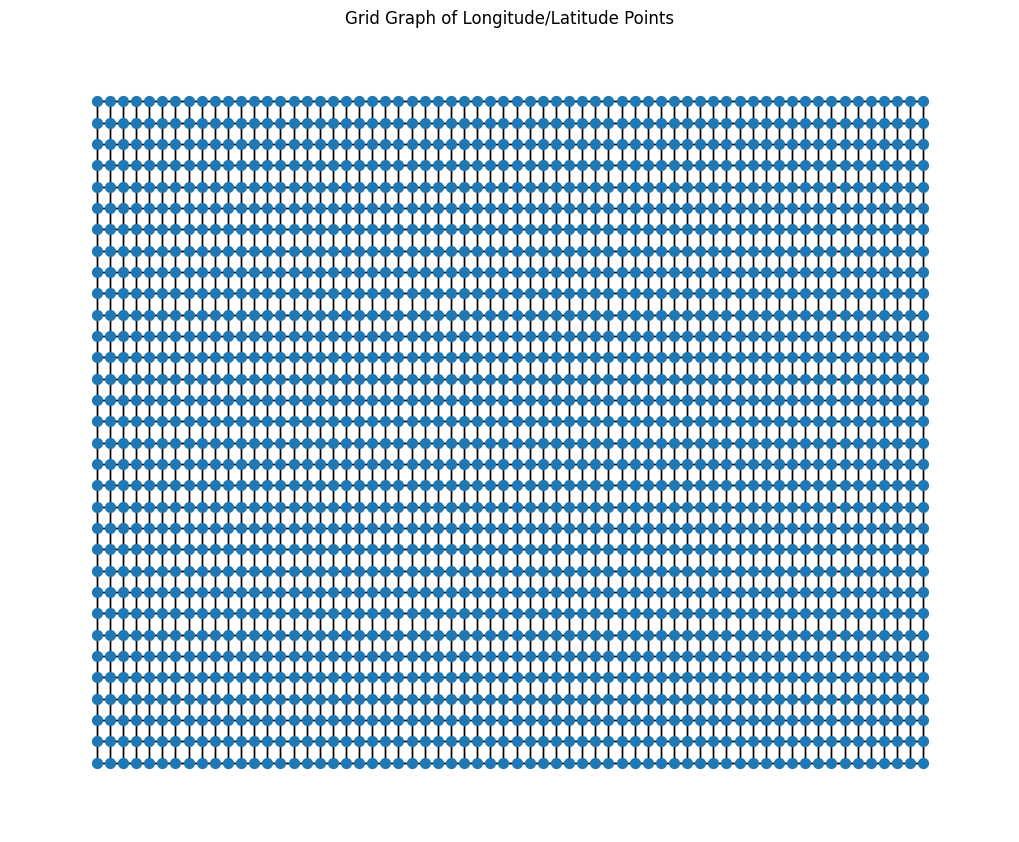

In [19]:
# Generate positions for the nodes (optional, for better visualization)
pos = {(lon, lat): (lon, lat) for lon in longitude for lat in latitude}

plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=False, node_size=50)
plt.title("Grid Graph of Longitude/Latitude Points")
plt.show()

TODO: Given a list of networkx graphs, make a data loader